# Monte Carlo Localization (MCL)

First thing, let's import some libraries:


In [ ]:
%matplotlib inline

from MCL.World import World
from MCL.Robot import Robot
from MCL.MCL import MCL
import inspect_MCL

import numpy as np
import matplotlib.pyplot as plt

*Note:* I treated the classes we got as open-source, hence,
I felt free to make some changes in them.

## Plotting Robots

In order to get more familiar with the `Robot` and `World` classes we were asked to
plot some robots in a world:

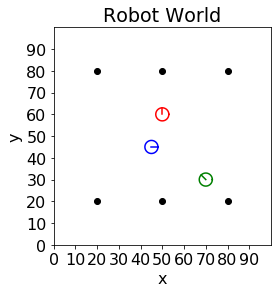

Robots Poses:
[x = 45, y = 45 heading = 0]
[x = 50, y = 60 heading = 1.571]
[x = 70, y = 30 heading = 2.356]


In [2]:
# Create the world & robots
poses = [(45, 45, 0), (50, 60, np.pi / 2), (70, 30, 3 * np.pi / 4)]
robots = [Robot(init_pose=p) for p in poses]
colors = ['blue', 'red', 'green']
world = World()

# Plot world & robots
world.plot()
for i in range(len(robots)):
    robots[i].plot(mycolor=colors[i])
plt.show()

# Print robots' poses
print('Robots Poses:')
print('\n'.join(map(str, robots)))

## Method `move()`

In order to implement a `move` method as required I used the given model
motion equations with some noise. First I injected a little noise into the motion commands
$u_1$ and $u_2$ as follows:

$$u_1 = u_1 + \delta_1, \quad \delta_1 \sim \mathcal{N}(0, \sigma_1)$$
$$u_2 = u_2 + \delta_2, \quad \delta_2 \sim \mathcal{N}(0, \sigma_2)$$

Then I implemented the motion model equations as part of the `move()` method.
After computing the new $(x,y,\theta)$ position I used the giving `set()` method
to set the current robot's position to the computed new position.

## Method `sense()`

Next we implemented a `sense` method which get list of landmarks, where
each landmark is a tuple of x and y position and return list of measurements.
Each measurement $i$ from the measurements list is also a tuple of
distance and bearing from the $i$ landmark. The follows equation
been used to compute the range and bearing:

$$range_i = \sqrt{(m_{i, x} - x)^2 + (m_{i, y} - y)^2} + \delta_{range}$$ <br>
$$bearing_i = \operatorname{atan2}(m_{i, y} - y, m_{i, x} - x) - \theta + \delta_{bearing}$$

where,

$$\delta_{range} \sim \mathcal{N}(0, \sigma_{range}), \quad \delta_{bearing} \sim \mathcal{N}(0, \sigma_{bearing})$$

and $i$ denote the $i$ landmark.

## Method `measurement_probability`

The `measurement_probability()` method gets the follow arguments:

1. `measurement` - the measurement we got when we used the `sense()` method,
in the form of $(r, \phi)$, usually known as $z_t$.

1. `landmark` - the position of the landmark we measured $(r, \phi)$ to it,
in the form of $(m_x,m_y)$, usually known as $m$

The method use the current position of the robot $(x,y,\theta)$ to compute the follows expression:

$$p(z_t | x_t, m) = p(r - \hat{r}, \sigma_r) * p(\phi - \hat{\phi}, \sigma_{\phi})$$

where:

$$\hat{r} = \sqrt{(m_x - x)^2 - (m_y - y)^2}, \quad \hat{\phi} = atan2(m_y - y, m_x - x) - \theta$$

The expression $p(r - \hat{r}, \sigma_r)$ means - the probability to observe
$(r - \hat{r})$ giving distribution of $\mathcal{N}(0, \sigma_{range})$. Same
for the $\theta$ measurement.

When I tried to use `norm` function from `scipy.stat` I noticed the long run time of
creating a norm distribution and getting a probability for a given $x$ value. Hence, I implemented
my own `norm_pdf(x, mean, std)` function which get `x` as a value and $(\mu, \sigma)$ as `mean` and `std`. The function
return the probability to observe the given $x$.

## Robot Motion - Without Noise

In order to plot the given commands I added an attribute to the `Robot` class. The new attribute is a list
named `path` and contains all the $(x, y)$ points the robot was located at them. In the
`__init__` method the initial pose append to `path` and in each call of the `move` method
the new position appended to the `path` list.

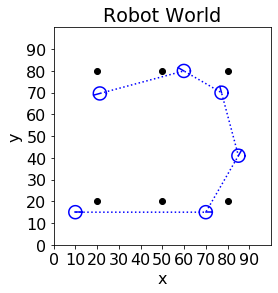

In [3]:
# Init world & robot
world = World()
robot = Robot(init_pose=(10, 15, 0))
moves = [(0, 60), (np.pi / 3, 30), (np.pi / 4, 30),
         (np.pi / 4, 20), (np.pi / 4, 40)]

# Init plot
world.plot()
robot.plot()

# Make the moves and plot them
for u_1, u_2 in moves:
    robot.move(u_1, u_2)
    robot.plot()

# Add the dotted line and plot
plt.plot(*(zip(*robot.path)), 'b:')
plt.show()


We can see the robot move perfectly without any noise in the motion commands. So now we
need to examine how it look like where we add some noise.

## Robot Motion - With Noise

We add another robot to the world, but now with some noise. The new robot's initial pose is also $(10,15,0)$
but the second robot will have noisy motor commands. The noise defined to be $\sigma_1=0.1$
and $\sigma_2 = 6$. Now we plot both robot moves on the same plot:


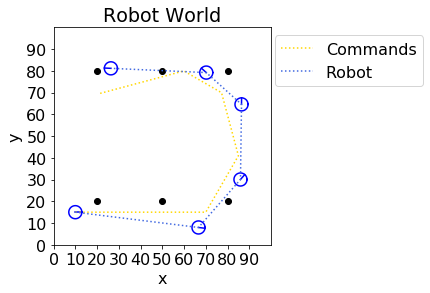

In [8]:
# Init both robots
ideal_robot = Robot(init_pose=(10, 15, 0))
robot = Robot(init_pose=(10, 15, 0),
              noise_std={'forward': 6, 'turn': 0.1, 'range': 5, 'bearing': 0.3})

# Init plot
world.plot()
robot.plot()

# Move both robots and plot the moves
for u_1, u_2 in moves:
    ideal_robot.move(u_1, u_2)
    robot.move(u_1, u_2)
    robot.plot()

# Add the robots' path
plt.plot(*(zip(*ideal_robot.path)), ':', color='gold', label='Commands')
plt.plot(*(zip(*robot.path)), ':', color='royalblue', label='Robot')
plt.legend(bbox_to_anchor=(0.98, 1), loc='upper left')
plt.show()

We can absolutely notice the noise in the robot motion. The gap
between the yellow and the blue paths indicate the noise in the robot motion.

## MCL Implementation

I implemented a class named `MCL` which warp the MCL algorithm. First you need to initialize
an instance of `MCL` class. The init function get robot to use the algorithm on his motion,
the landmarks in the world and number of particles. The main method in `MCL` class is `localize()`.
The method update the estimated location of the robot by a given motion command $u_t$ and
measurement of the robot $z_t$. The method uses these arguments for the following steps:

1. _Move_ the particles according to the motion command.

1. _Weight_ each particle according to the robot measurements.

1. _Resample_ the particles according to the weight of each particle.

1. _Estimate_ the new position of the robot as the mean of the resampled particles.

The current estimated position of the robot can be reached by `get_estimated_location()`
method, which return $(x, y)$ position.

Now lets make some plots.

First, we initialize variables for the MCL algorithm.

In [5]:
world = World()
ideal_robot = Robot(init_pose=(10, 15, 0))  # without noise for the command path
robot = Robot(init_pose=(10, 15, 0),
              noise_std={'forward': 6, 'turn': 0.1, 'range': 5, 'bearing': 0.3})
moves = [(0, 60), (np.pi / 3, 30), (np.pi / 4, 30),
         (np.pi / 4, 20), (np.pi / 4, 40)]
n_particles= 1000
mcl = MCL(robot, world.landmarks, n_particles)


Now we use the `mcl` instance to estimate the robot position after each move:


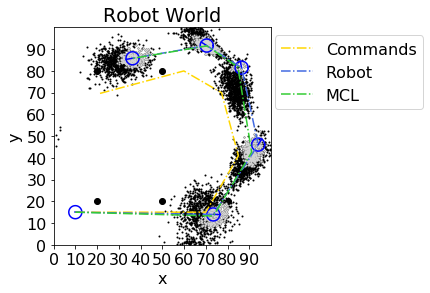

In [6]:
# Init plot
world.plot()
robot.plot()

for u in moves:

    ideal_robot.move(u[0], u[1])
    robot.move(u[0], u[1])
    mcl.localize(u, robot.sense(world.landmarks))
    robot.plot()

# Plot paths
plt.plot(*(zip(*ideal_robot.path)), '-.', color='gold', label='Commands')
plt.plot(*(zip(*robot.path)), '-.', color='royalblue', label='Robot')
plt.plot(*(zip(*mcl.path)), '-.', color='limegreen', label='MCL')
plt.legend(bbox_to_anchor=(0.98, 1), loc='upper left')
plt.show()

That's look nice!

We can notice the noise in the robot command by the gap between
the 'Commands' line (yellow) and the 'Robot' line (blue). Although the
gap, the MCL algorithm succeed to localize the robot position very well!

Another interesting thing is the MCL give better result when the robot make
more noisy motion. I think it because when the robot make a 'normal' motion there
more particles with high probability. In the other hand, where the robot make
very noisy motion only few particles get high probability, so the MCL will be more confident
about the estimation.

## MCL Inspection

I was curious to know the influence of the particles' amount on the
estimation error of the algorithm. Hence, in the `inspect_MCL.py` script
I ran 60 times MCL algorithm with different number of particles.
I measured the error of the MCL algorithm using euclidean distance between the
robot position and the MCL estimation. Using the follows command I
got my desired results file:

```{python}
inspect_MCL.inspect_particles(n_repeat=60, n_particles=[50, 250, 500, 1000, 2000])
```

Then I plotted the results where size of particle set in the x-axis
and the error in the y-axis. I plotted the mean and std of each amount of particles
I used:


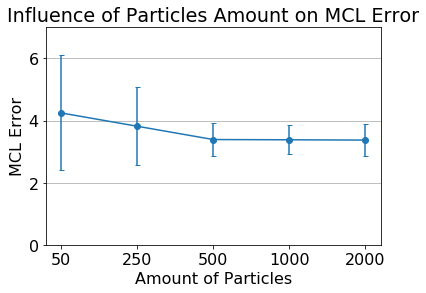

In [9]:
inspect_MCL.plot_inspect_particles(results_path='results/particles_results.csv')


We can easily notice that the accuracy of the of the approximation is determined
by the size of the particle set. Increasing the total number of particles increases
the accuracy of the approximation. But of course there is a trade-off between
the size of particle set and the computational resources necessary to run MCL.
So, it look like determined $N=1000$ was a good choice after all.

Another thing I was interested is the about improving the estimation of the algorithm.
I thought about changing the regular average the MCL calculated of all the resampled particles with
weighted average (WA). I thought that using the weight of each particle where estimating the robot location
can improve the estimations of the algorithm. Hence, I added a bool argument in the `__init__`
method of the `MCL` class which indicate if to estimate the position of the robot using
WA (`True`) or with simple average (`False`). I used both type of algorithm for
estimating 100 times a robot path using:

```{python}
inspect_MCL.inspect_WA(n_repeat=100)
```

Then I plotted the results:

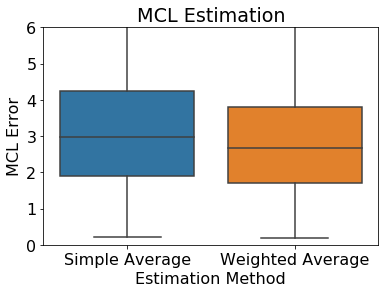

In [10]:
inspect_MCL.plot_inspect_WA(results_path='results/WA_results.csv')


We can see the WA did improve the the MCL estimations. The improvement
is not big, but it not demand a lot in the aspect of run time and memory.
Hence, I think it is a pretty good improvement for the MCL estimation :)


